In [1]:
import pandas as pd
import openml
import data_preprocess as dp

data_name = 'elevators'

data = openml.datasets.get_dataset(846)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

# Data Preprocessing

In [2]:
from copy import deepcopy
import numpy as np

nominal = [b for a, b in zip(categorical_indicator, attribute_names) if a]
numerical = [b for a, b in zip(categorical_indicator, attribute_names) if not a]


encoded_data = deepcopy(X)

for col in nominal:
    
    mapping = {c: i+1 for i, c in enumerate(encoded_data[col].unique())}
    encoded_data[col] = encoded_data[col].replace(mapping)
    try:
        encoded_data[col] = encoded_data[col].cat.add_categories([0])
    except:
        continue

encoded_data = encoded_data[numerical + nominal]
encoded_data.fillna(0, inplace=True)

In [3]:
mapping = {b: i for i, b in enumerate(y.unique())}


y = y.replace(mapping)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

train_data, left_out, train_label, y_left_out = train_test_split(encoded_data, y, test_size=0.3, 
                                                                 stratify=y, random_state=42)
test_data, dev_data, test_label, dev_label = train_test_split(left_out, y_left_out, test_size=0.5, 
                                                              stratify=y_left_out, random_state=42)

In [5]:
from sklearn.preprocessing import Normalizer, StandardScaler

ss = StandardScaler()

ss.fit(train_data[numerical])

train_data[numerical] = ss.transform(train_data[numerical])
dev_data[numerical] = ss.transform(dev_data[numerical])
test_data[numerical] = ss.transform(test_data[numerical])

In [6]:
index_to_name, name_to_index = dp.name_index(data=encoded_data)

In [7]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train_data, train_label)

In [8]:
train = dp.transform_to_tensors(X_over, y_over, len(index_to_name))

test = dp.transform_to_tensors(test_data, test_label, len(index_to_name))

dev = dp.transform_to_tensors(dev_data, dev_label, len(index_to_name))


torch.Size([16056, 18])
torch.Size([16056])
torch.Size([2490, 18])
torch.Size([2490])
torch.Size([2490, 18])
torch.Size([2490])


In [9]:
from torch.utils.data import DataLoader
import torch

batch_size = 64

train_dataset = dp.Data(data=train)
val_dataset = dp.Data(data=dev)
test_dataset = dp.Data(data=test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Train MLP

In [10]:
import torch
import os.path
from mlpshap import train_model, MLPSHAP
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
torch.manual_seed(5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.isfile(f'{data_name}/{data_name}_mlp.model'):
    
    print('Loading saved model')
    mlp_model = MLPSHAP(len(index_to_name), 1, index_to_name, dataframe=encoded_data, 
            categorical=nominal, 
            numerical=numerical,).to(device)
    mlp_model.load_state_dict(torch.load(f'{data_name}/{data_name}_mlp.model'))
    
else:
    mlp_model = train_model(index_to_name=index_to_name,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                data_name=data_name,
                num_classes=1,
                dataframe=encoded_data, 
                categorical=nominal, 
                numerical=numerical,
                mlp_model=None, 
                optimizer_train=None, 
                current_epoch=1,
                max_num_epochs=300,
                learning_rate=1e-03,
                num_samples=32,
                alpha=1, beta=10,
                patience=10)


Loading saved model


## Evaluate the trained model on the test set

In [11]:
from tqdm import tqdm

list_prediction = []
list_pob_pred = []
y_test = []

mlp_model.eval()

for i, data in tqdm(list(enumerate(test_dataloader))):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = mlp_model(inputs)
    list_pob_pred.extend(outputs.tolist())

    preds = (outputs.reshape(-1) > 0.5) * 1

    list_prediction.extend(preds.tolist())

    y_test.extend(labels.tolist())

    torch.cuda.empty_cache()


roc = roc_auc_score(y_test, list_pob_pred)
prec = precision_score(y_test, list_prediction, average='macro')
recall = recall_score(y_test, list_prediction, average='macro')
f_score = f1_score(y_test, list_prediction, average='macro')

print('AUC is : {},  prec {},  recall {}, f-score {}' .format(roc, prec, recall, f_score))

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 102.63it/s]

AUC is : 0.9427016007248565,  prec 0.8267967362466289,  recall 0.8601140138930836, f-score 0.8380899776417114


# Explain one random example

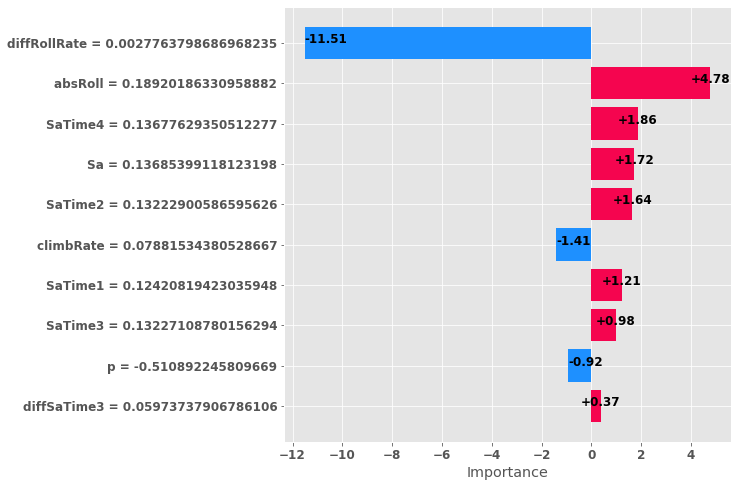

tensor([[0.2391]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [13]:
#num of features to use
top_n = 10
ind = np.random.choice(len(test))

mlp_model.plot_bars(test[10][0].reshape(1, len(index_to_name)).to(device), test_data.iloc[0], top_n)
mlp_model.predict(test[10][0].reshape(1, len(index_to_name)).to(device))

# Interpretability Evaluation

In [14]:
'''function to obtain feature scores from IGNNet model'''

def get_local_values(example, index_to_name):
    array_to_use = np.array(example)    
    array = torch.FloatTensor(array_to_use).reshape(1, len(index_to_name))
    local_importance = mlp_model.get_local_importance(array.to(device))

    names = []
    values = []
    for i, v in enumerate(local_importance):
        name = index_to_name[i]
        names.append(name)
        values.append(v)
    return names, values

In [15]:
from sklearn.preprocessing import StandardScaler
from data_preprocess import BlackBoxWrapper


num_features = len(index_to_name)


bb = BlackBoxWrapper(mlp_model, num_features, device)

def black_box(x, S):
    pred = bb(x, S)
    return pred.cpu().data.numpy()

In [19]:
from tqdm import tqdm
import shapreg
import pickle
import os.path
from numpy.linalg import norm
from scipy.stats import spearmanr
import copy

all_cos_sim = []
all_spearman_c = []
all_krnl = []

for x_, _ in tqdm(test_dataset):
    _, true_values = get_local_values(x_, index_to_name)

    x = x_.reshape((1,x_.shape[0])).numpy()

    # Run KernelSHAP to convergence
    game_ = shapreg.games.PredictionGame(black_box, x)
    try:
        shap_values, all_results = shapreg.shapley.ShapleyRegression(
            game_, batch_size=256, paired_sampling=True, detect_convergence=True,
            bar=False, return_all=True)
    except:
        print('Singularity exception!')
        continue

    instance_l2_dis = []
    instance_cos_sim = []
    spearman_c = []

    true_values = np.array(true_values)

    knl_shp = shap_values.values.reshape(-1)
    all_krnl.append(shap_values)

    all_cos_sim.append(np.dot(true_values, knl_shp)/(norm(true_values)*norm(knl_shp)))
    coef, p = spearmanr(true_values, knl_shp)
    all_spearman_c.append(coef)

mean_cos_sim = np.mean(all_cos_sim)
mean_spearman_c = np.mean(all_spearman_c)

std_cos_sim = np.std(all_cos_sim)
std_spearman_c = np.std(all_spearman_c)

print('Cosine similarity: {} +- {},  Spearman rank: {} +- {}' .format(mean_cos_sim, std_cos_sim, 
                                                                      mean_spearman_c, std_spearman_c))

with open(f'{data_name}/{data_name}_krnlshp_mlp.pickle', 'wb') as file:
    pickle.dump(all_krnl, file)

100%|████████████████████████████████████████████████████████████████████████████████| 2490/2490 [07:21<00:00,  5.64it/s]

Cosine similarity: 0.9755798604909318 +- 0.024766525912254037,  Spearman rank: 0.8829539002242199 +- 0.06600808547530039
